# 0. 어제 오른 내 주식, 과연 내일은?

과거의 주식 데이터를 통해 미래의 주식을 예측해보자.

데이터 출처

야후 파이낸스: https://finance.yahoo.com/  
* 삼성 주식 데이터: https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS  
* 애플 주식 데이터: https://finance.yahoo.com/quote/AAPL/history?p=AAPL  
* 마이크로소프트 주식 데이터: https://finance.yahoo.com/quote/MSFT/history?p=MSFT

## 0.1 목차

[1. 삼성 주식 예측](#1.-삼성-주식-예측)  
[1-1. 시계열 데이터 준비](#1-1.-시계열-데이터-준비)  
[1-2. 각종 전처리 수행](#1-2.-각종-전처리-수행)  
* 결측치 처리  
* 로그 변환  

[1-3. 시계열 안정성 분석](#1-3.-시계열-안정성-분석)  
* 정성적 그래프 분석  
* 정량적 Augmented Dicky-Fuller Test  
* 시계열 분해(Time Series Decomposition)  
* Residual 안정성 확인  

[1-4. 적정 ARIMA 모수 찾기](#1-4.-적정-ARIMA-모수-찾기)  
* ACF, PACF 그려보기 -> p,q 구하기  
* 차분 안정성 확인 -> d 구하기  

[1-5. 학습, 테스트 데이터셋 생성](#1-5.-학습,-테스트-데이터셋-생성)  
* 학습, 테스트 데이터셋 분리  

[1-6. ARIMA 모델 훈련과 테스트](#1-6.-ARIMA-모델-훈련과-테스트)  
* ACF, PACF 그려보기 -> p,q 구하기  
* 차분 안정성 확인 -> d 구하기  

[2. 애플 주식 예측](#1.-애플-주식-예측)  
위 스텝 반복

[3. 마이크로소프트 주식 예측](#1.-마이크로소프트-주식-예측)  
위 스텝 반복

세 기업의 주가 데이터는 모두 같은 특징들을 가진 데이터이다.

* Feature  
Date: 날짜  
Open: 시작가  
High: 최고가  
Low: 최저가  
Close: 종가  
Adj Close: 수정종가  
Volume: 거래량

이 중 다른 변수는 쓰지 않고 Date를 index로 하고 Close를 value로 하는 series를 사용하겠다.  
(참고. 주식 시장은 정해진 시간 동안만 거래가 가능하다. 종가란 하루의 장이 마감하였을 때의 가격이다.)

In [108]:
import os
import warnings
warnings.filterwarnings('ignore') #경고 무시

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller # 확장된 Dickey-Fuller 검정
from statsmodels.tsa.seasonal import seasonal_decompose # 시계열 분해
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # 자기상관도표, 편자기상관도표
from statsmodels.tsa.arima.model import ARIMA # 자동 회귀 통합 이동 평균

from sklearn.metrics import mean_squared_error, mean_absolute_error # MSE, MAE
import math # 수학


# 1. 삼성 주식 예측

## 1-1. 시계열 데이터 준비

In [109]:
samsung_path = os.getenv('USERPROFILE') + '\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\[E-04]\data\SamsungStock.csv'
# index를 Date 변수로 지정하고 index를 DatetimeIndex으로 변환
samsung_df = pd.read_csv(samsung_path, index_col='Date', parse_dates=True)
samsung = samsung_df['Close'] # Clone 변수만 추출

samsung.head()

Date
2021-09-29    74100.0
2021-09-30    74100.0
2021-10-01    73200.0
2021-10-05    72200.0
2021-10-06    71300.0
Name: Close, dtype: float64

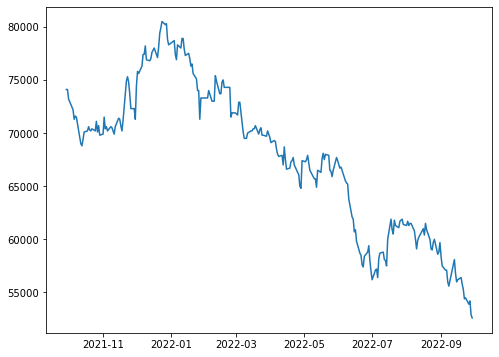

In [110]:
plt.plot(samsung)

## 1-2. 각종 전처리 수행

In [111]:
# 시계열인 index를 앞, 뒤 값과 자연스럽게 연결되게 결측값 처리
samsung = samsung.interpolate(method='time')
samsung[samsung.isna()] # 처리 확인

Series([], Name: Close, dtype: float64)

In [112]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [113]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [114]:
# 로그 변환
samsung = np.log(samsung)

## 1-3. 시계열 안정성 분석

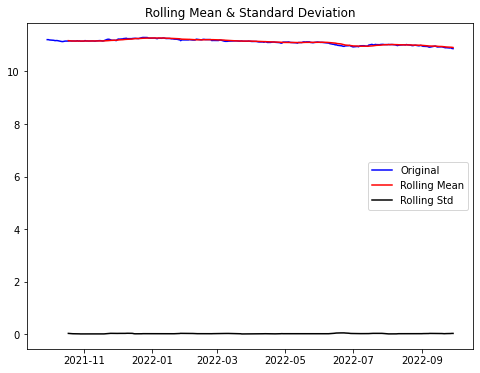

Results of Dickey-Fuller Test:
Test Statistic                   0.141846
p-value                          0.968805
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


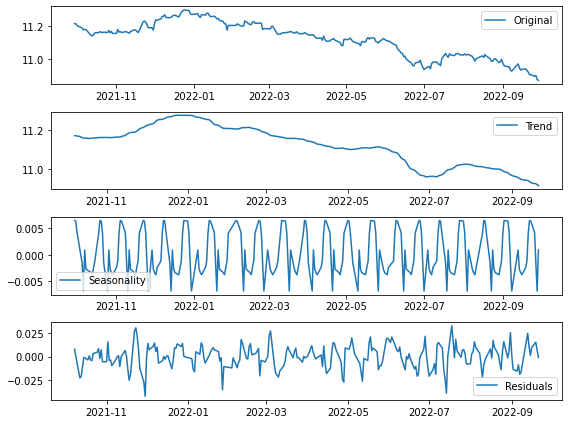

In [115]:
# 정성적 그래프 분석
plot_rolling_statistics(samsung)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(samsung)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(samsung, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (8,6)
plt.subplot(411)
plt.plot(samsung, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

플로팅을 해 봤을 때 평균이 일정하고 분산이 일정하므로 안정성이 있어보인다.  
하지만 adft 결과 p-value가 0.05보다 작지 않으므로 안정성이 없다고 보는 것이 타당하다.

In [116]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.951355e+00
p-value                        2.509819e-17
#Lags Used                     4.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


## 1-4. 적정 ARIMA 모수 찾기

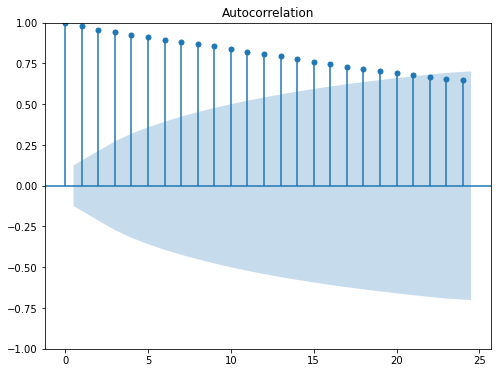

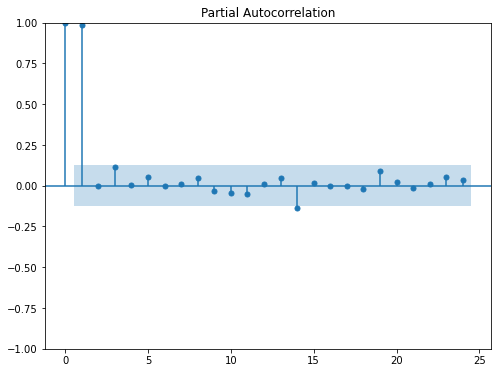

In [117]:
plot_acf(samsung)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(samsung)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.217469e+01
p-value                        1.394918e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.200663e+00
p-value                        2.006205e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


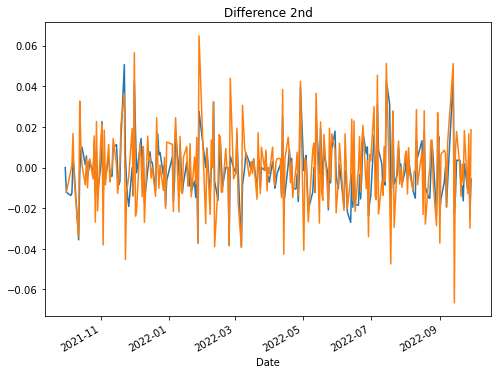

In [118]:
# 1차 차분 구하기
samsung_d1 = samsung.diff(periods=1).iloc[1:]
samsung_d1.plot(title='Difference 1st')

augmented_dickey_fuller_test(samsung_d1)

# 혹시 필요한 경우 2차 차분 구하기
samsung_d11 = samsung_d1.diff(periods=1).iloc[1:]
samsung_d11.plot(title='Difference 2nd')

augmented_dickey_fuller_test(samsung_d11)


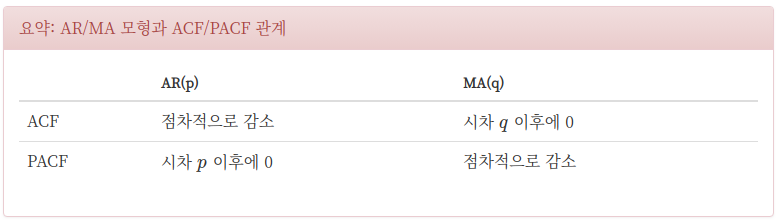

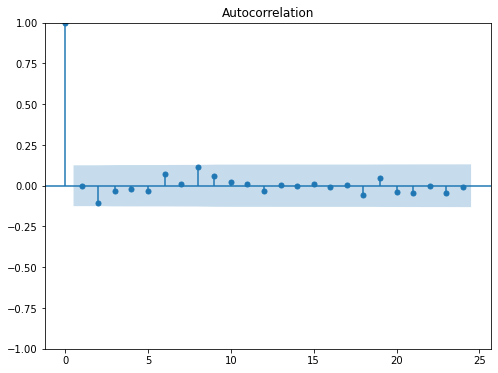

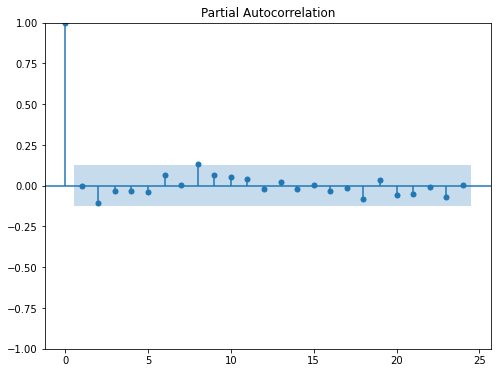

In [119]:
plot_acf(samsung_d1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(samsung_d1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

1차 차분 후 adft 결과 p-value가 0.05보다 작으므로 안정성이 있다고 보는 것이 타당하다.  
pacf 그래프를 봤을 때 p가 1 이상인 구간에서 pacf가 거의 0에 가까워지고 있기 때문에 p=0이 매우 적합해 보인다.  
acf 그래프를 봤을 때 q가 1 이상인 구간에서 acf가 거의 0에 가까워지고 있기 때문에 q=0이 매우 적합해 보인다.  

따라서 아리마 모수 (p, d, q) = (0, 1, 0)

## 1-5. 학습, 테스트 데이터셋 생성

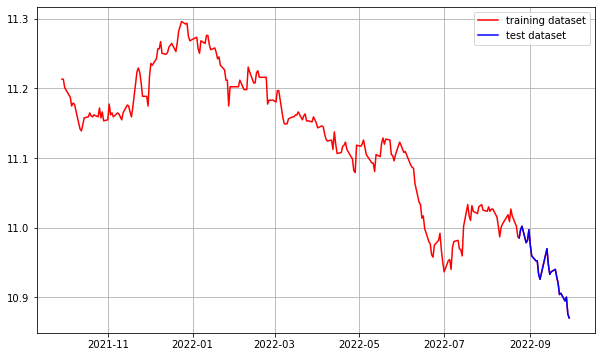

In [120]:
samsung_train_len = int(len(samsung) * 0.9)
samsung_train, samsung_test = samsung[: samsung_train_len], samsung[samsung_train_len: ]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(samsung, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 samsung를 선택
plt.plot(samsung_test, c='b', label='test dataset')
plt.legend()

## 1-6. ARIMA 모델 훈련과 테스트

In [121]:
samsung_arima = ARIMA(samsung_train, order = (0, 1, 0))
samsung_arima_fit = samsung_arima.fit()

print(samsung_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 636.231
Date:                Fri, 30 Sep 2022   AIC                          -1270.463
Time:                        23:00:01   BIC                          -1267.069
Sample:                             0   HQIC                         -1269.092
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   1.26e-05     14.281      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                43.49
Prob(Q):                              0.70   Pr

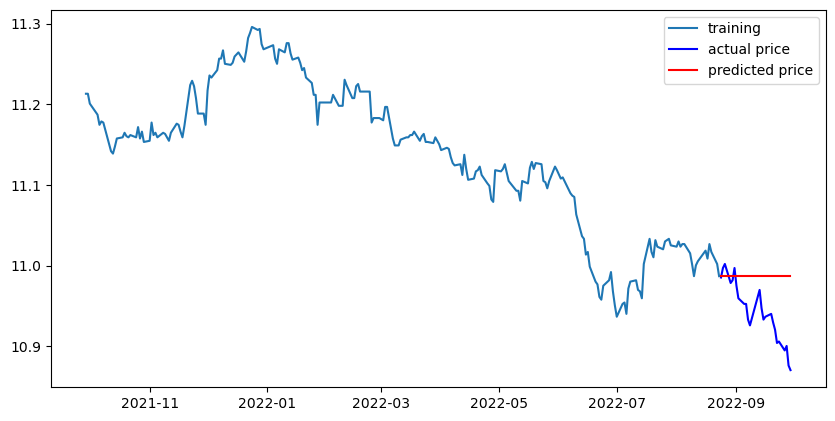

In [122]:
# Forecast : 결과가 fc에 담깁니다. 
samsung_fore = samsung_arima_fit.forecast(len(samsung_test), alpha=0.05)  # 95% conf
samsung_fore.index = samsung_test.index
# Make as pandas series

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(samsung_train, label='training')
plt.plot(samsung_test, c='b', label='actual price')
plt.plot(samsung_fore, c='r',label='predicted price')
plt.legend()
plt.show()

In [123]:
mse = mean_squared_error(np.exp(samsung_test), np.exp(samsung_fore))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(samsung_test), np.exp(samsung_fore))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(samsung_test), np.exp(samsung_fore)))
print('RMSE: ', rmse)

mape = np.mean(np.abs((np.exp(samsung_test) - np.exp(samsung_fore))/np.exp(samsung_test)))
print('MAPE: {:.2f}%'.format(mape * 100))

MSE:  10668400.00000017
MAE:  2684.0000000000277
RMSE:  3266.251674320301
MAPE: 4.87%


# 2. 애플 주식 예측

In [124]:
apple_path = os.getenv('USERPROFILE') + '\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\[E-04]\data\AppleStock.csv'
apple_df = pd.read_csv(apple_path, index_col='Date', parse_dates=True)
apple = apple_df['Close']

apple.head()

Date
2021-09-28    141.910004
2021-09-29    142.830002
2021-09-30    141.500000
2021-10-01    142.649994
2021-10-04    139.139999
Name: Close, dtype: float64

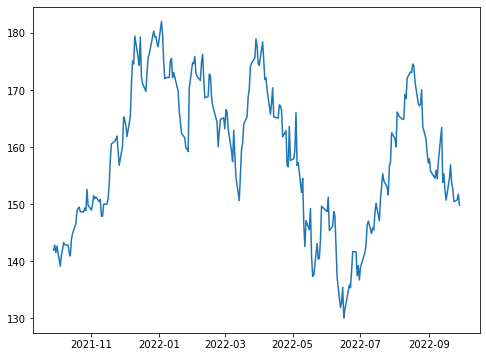

In [125]:
plt.plot(apple)

In [126]:
# 결측치 처리
apple = apple.interpolate(method='time')
apple[apple.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [127]:
# 로그 변환 시도 
apple = np.log(apple)

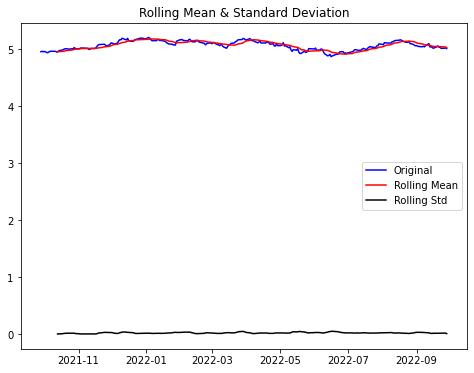

Results of Dickey-Fuller Test:
Test Statistic                  -2.187499
p-value                          0.210814
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


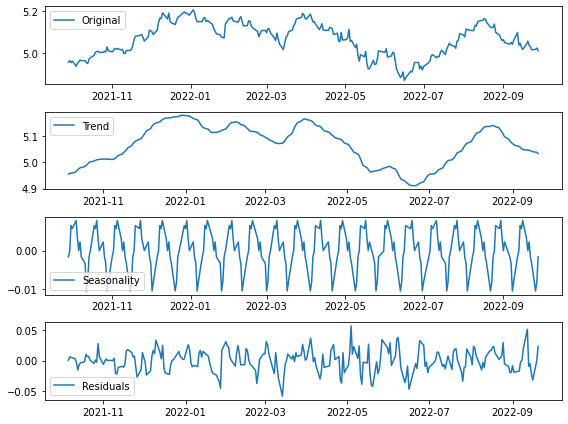

In [128]:
# 정성적 그래프 분석
plot_rolling_statistics(apple)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(apple)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(apple, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (8,6)
plt.subplot(411)
plt.plot(apple, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

플로팅을 해 봤을 때 평균이 일정하고 분산이 일정하므로 안정성이 있어보인다.  
하지만 adft 결과 p-value가 0.05보다 작지 않으므로 안정성이 없다고 보는 것이 타당하다.

In [129]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.361478e+00
p-value                        2.468328e-08
#Lags Used                     1.300000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


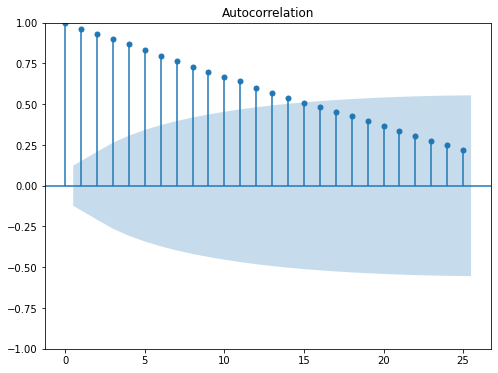

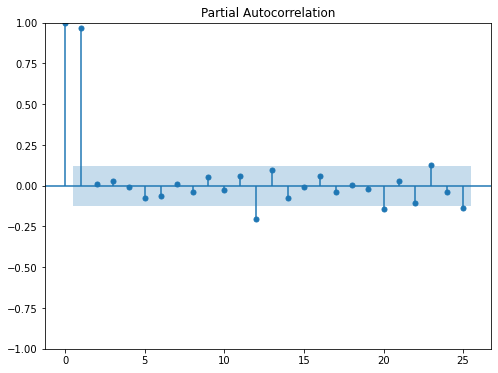

In [130]:
plot_acf(apple)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(apple)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.609271e+01
p-value                        5.232473e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.962733e+00
p-value                        2.919157e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


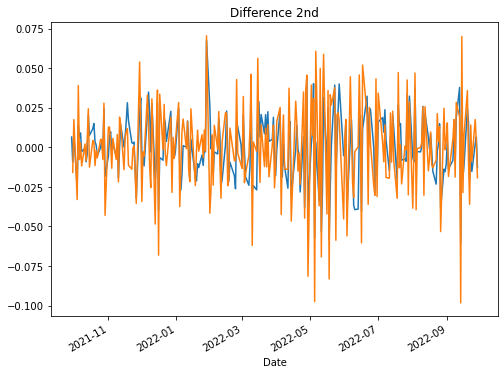

In [131]:
# 1차 차분 구하기
apple_d1 = apple.diff(periods=1).iloc[1:]
apple_d1.plot(title='Difference 1st')

augmented_dickey_fuller_test(apple_d1)

# 혹시 필요한 경우 2차 차분 구하기
apple_d11 = apple_d1.diff(periods=1).iloc[1:]
apple_d11.plot(title='Difference 2nd')

augmented_dickey_fuller_test(apple_d11)


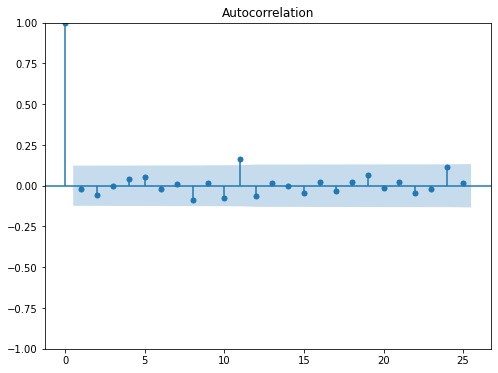

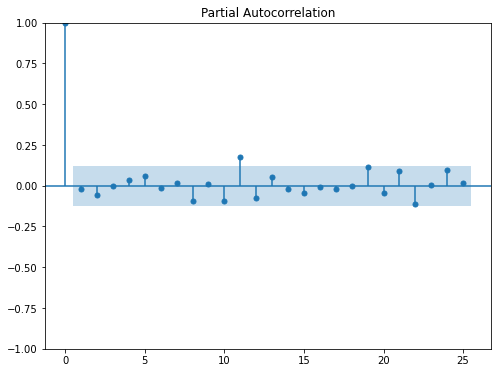

In [132]:
plot_acf(apple_d1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(apple_d1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

1차 차분 후 adft 결과 p-value가 0.05보다 작으므로 안정성이 있다고 보는 것이 타당하다.  
pacf 그래프를 봤을 때 p가 1 이상인 구간에서 pacf가 거의 0에 가까워지고 있기 때문에 p=0이 매우 적합해 보인다.  
acf 그래프를 봤을 때 q가 1 이상인 구간에서 acf가 거의 0에 가까워지고 있기 때문에 q=0이 매우 적합해 보인다.  

따라서 아리마 모수 (p, d, q) = (0, 1, 0)

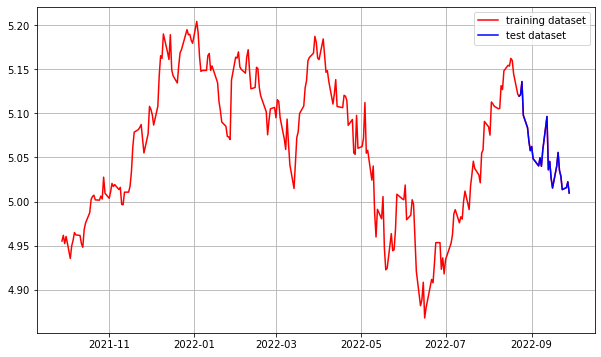

In [133]:
apple_train_len = int(len(apple) * 0.9)
apple_train, apple_test = apple[: apple_train_len], apple[apple_train_len: ]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(apple, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 apple를 선택
plt.plot(apple_test, c='b', label='test dataset')
plt.legend()

In [134]:
apple_arima = ARIMA(apple_train, order = (0, 1, 0))
apple_arima_fit = apple_arima.fit()

print(apple_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 566.300
Date:                Fri, 30 Sep 2022   AIC                          -1130.601
Time:                        23:00:03   BIC                          -1127.180
Sample:                             0   HQIC                         -1129.220
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   3.39e-05     11.514      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.52
Prob(Q):                              1.00   Pr

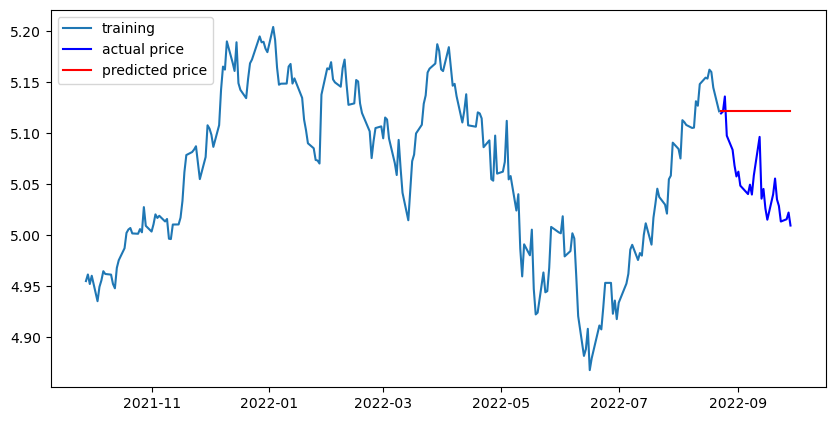

In [135]:
# Forecast : 결과가 fc에 담깁니다. 
apple_fore = apple_arima_fit.forecast(len(apple_test), alpha=0.05)  # 95% conf
apple_fore.index = apple_test.index
# Make as pandas series

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(apple_train, label='training')
plt.plot(apple_test, c='b', label='actual price')
plt.plot(apple_fore, c='r',label='predicted price')
plt.legend()
plt.show()

In [136]:
mse = mean_squared_error(np.exp(apple_test), np.exp(apple_fore))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(apple_test), np.exp(apple_fore))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(apple_test), np.exp(apple_fore)))
print('RMSE: ', rmse)

mape = np.mean(np.abs((np.exp(apple_test) - np.exp(apple_fore))/np.exp(apple_test)))
print('MAPE: {:.2f}%'.format(mape * 100))

MSE:  144.71074660008242
MAE:  10.90154580769226
RMSE:  12.029577989276365
MAPE: 7.07%


## 2-1. 번외 ARIMA 모수 (0, 0, 14)

In [137]:
apple_arima = ARIMA(apple_train, order = (0, 0, 14))
apple_arima_fit = apple_arima.fit()

print(apple_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(0, 0, 14)   Log Likelihood                 570.073
Date:                Fri, 30 Sep 2022   AIC                          -1108.145
Time:                        23:00:06   BIC                          -1053.346
Sample:                             0   HQIC                         -1086.033
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0628      0.015    329.623      0.000       5.033       5.093
ma.L1          1.0890      0.066     16.494      0.000       0.960       1.218
ma.L2          1.0052      0.089     11.349      0.0

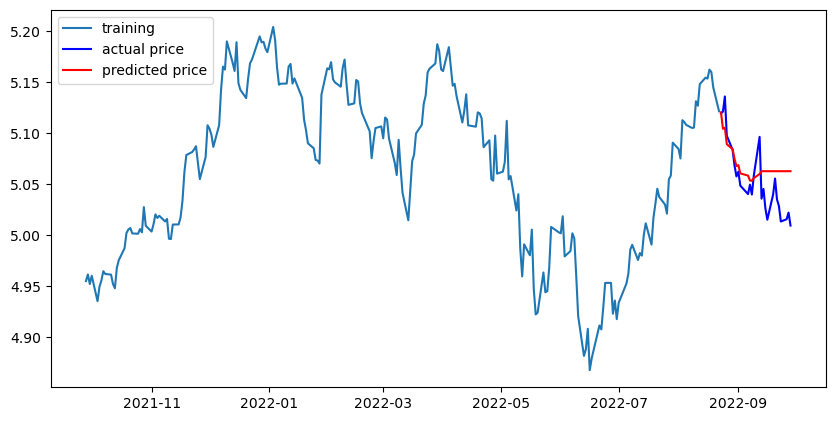

In [138]:
# Forecast : 결과가 fc에 담깁니다. 
apple_fore = apple_arima_fit.forecast(len(apple_test), alpha=0.05)  # 95% conf
apple_fore.index = apple_test.index
# Make as pandas series

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(apple_train, label='training')
plt.plot(apple_test, c='b', label='actual price')
plt.plot(apple_fore, c='r',label='predicted price')
plt.legend()
plt.show()

In [139]:
mse = mean_squared_error(np.exp(apple_test), np.exp(apple_fore))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(apple_test), np.exp(apple_fore))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(apple_test), np.exp(apple_fore)))
print('RMSE: ', rmse)

mape = np.mean(np.abs((np.exp(apple_test) - np.exp(apple_fore))/np.exp(apple_test)))
print('MAPE: {:.2f}%'.format(mape * 100))

MSE:  18.439911527625735
MAE:  3.476410122327371
RMSE:  4.294171809281242
MAPE: 2.25%


# 3. 마이크로소프트 주식 예측


In [140]:
microsoft_path = os.getenv('USERPROFILE') + '\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\[E-04]\data\MicrosoftStock.csv'
microsoft_df = pd.read_csv(microsoft_path, index_col='Date', parse_dates=True)
microsoft = microsoft_df['Close']

microsoft.head()

Date
2021-09-28    283.519989
2021-09-29    284.000000
2021-09-30    281.920013
2021-10-01    289.100006
2021-10-04    283.109985
Name: Close, dtype: float64

In [141]:
# 결측치 처리
microsoft = microsoft.interpolate(method='time')
microsoft[microsoft.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [142]:
# 로그 변환 시도 
microsoft = np.log(microsoft)

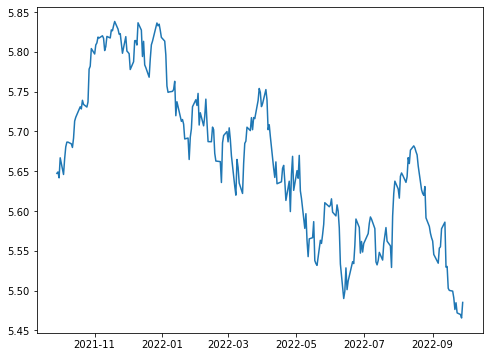

In [143]:
plt.plot(microsoft)

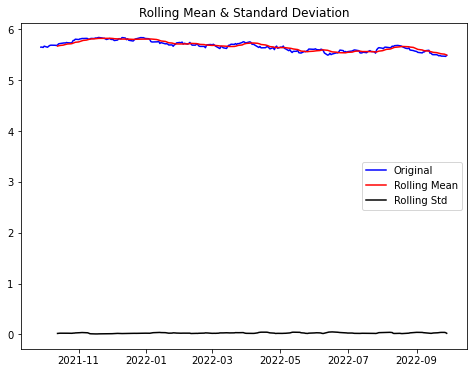

Results of Dickey-Fuller Test:
Test Statistic                  -1.056705
p-value                          0.732025
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


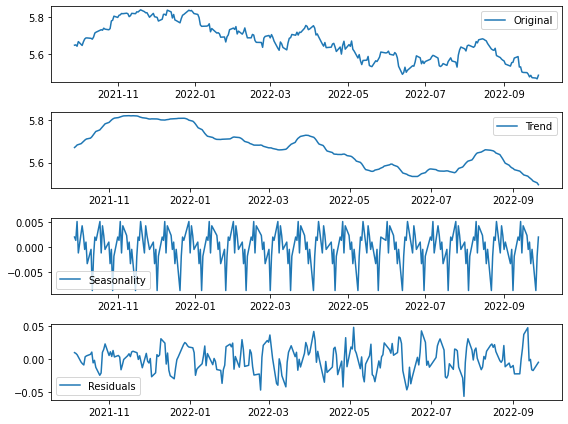

In [144]:
# 정성적 그래프 분석
plot_rolling_statistics(microsoft)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(microsoft)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(microsoft, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (8,6)
plt.subplot(411)
plt.plot(microsoft, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

플로팅을 해 봤을 때 평균이 일정하고 분산이 일정하므로 안정성이 있어보인다.  
하지만 adft 결과 p-value가 0.05보다 작지 않으므로 안정성이 없다고 보는 것이 타당하다.

In [145]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.587095e+00
p-value                        7.268661e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


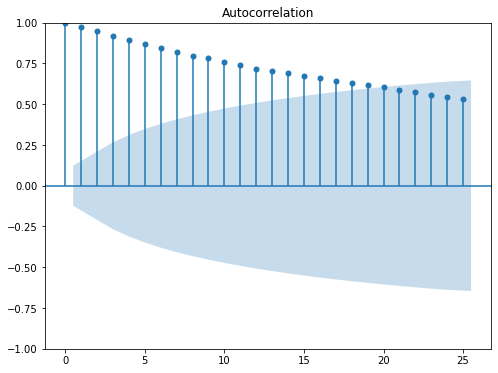

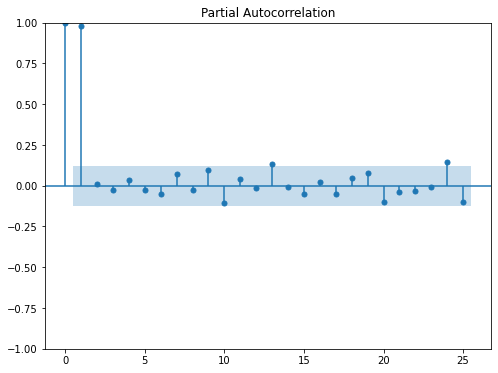

In [146]:
plot_acf(microsoft)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(microsoft)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.682708e+01
p-value                        1.165915e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.129954e+00
p-value                        3.040971e-15
#Lags Used                     8.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


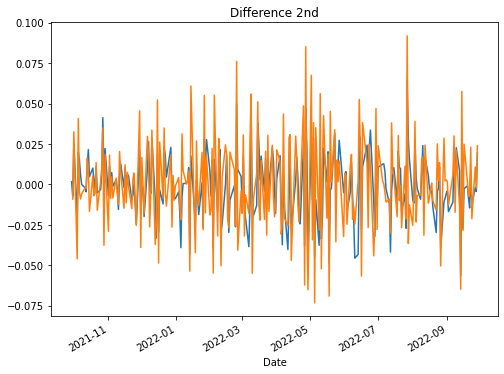

In [147]:
# 1차 차분 구하기
microsoft_d1 = microsoft.diff(periods=1).iloc[1:]
microsoft_d1.plot(title='Difference 1st')

augmented_dickey_fuller_test(microsoft_d1)

# 혹시 필요한 경우 2차 차분 구하기
microsoft_d11 = microsoft_d1.diff(periods=1).iloc[1:]
microsoft_d11.plot(title='Difference 2nd')

augmented_dickey_fuller_test(microsoft_d11)


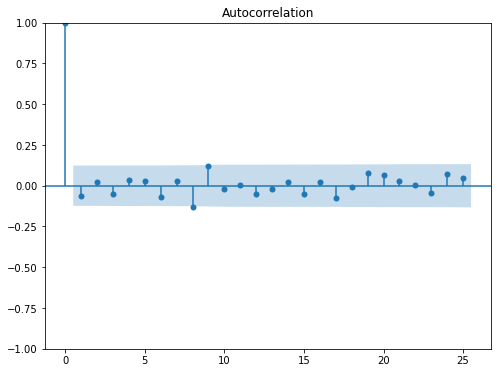

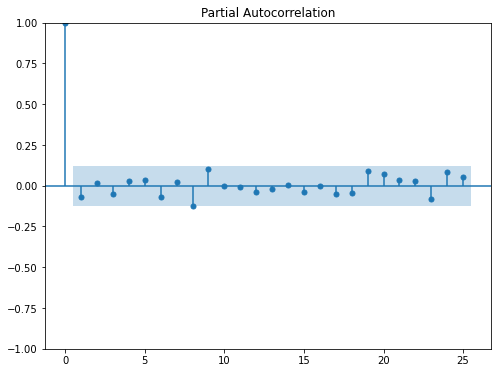

In [148]:
plot_acf(microsoft_d1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(microsoft_d1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

1차 차분 후 adft 결과 p-value가 0.05보다 작으므로 안정성이 있다고 보는 것이 타당하다.  
pacf 그래프를 봤을 때 p가 1 이상인 구간에서 pacf가 거의 0에 가까워지고 있기 때문에 p=0이 매우 적합해 보인다.  
acf 그래프를 봤을 때 q가 1 이상인 구간에서 acf가 거의 0에 가까워지고 있기 때문에 q=0이 매우 적합해 보인다.  

따라서 아리마 모수 (p, d, q) = (0, 1, 0)

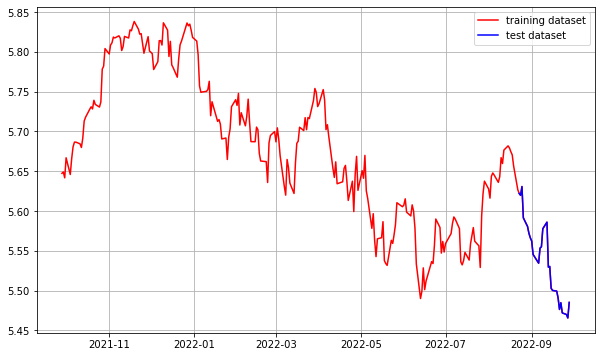

In [149]:
microsoft_train_len = int(len(microsoft) * 0.9)
microsoft_train, microsoft_test = microsoft[: microsoft_train_len], microsoft[microsoft_train_len: ]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(microsoft, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 microsoft를 선택
plt.plot(microsoft_test, c='b', label='test dataset')
plt.legend()

In [150]:
microsoft_arima = ARIMA(microsoft_train, order = (0, 1, 0))
microsoft_arima_fit = microsoft_arima.fit()

print(microsoft_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 566.175
Date:                Fri, 30 Sep 2022   AIC                          -1130.349
Time:                        23:00:08   BIC                          -1126.929
Sample:                             0   HQIC                         -1128.969
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   3.54e-05     11.039      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.29   Pr

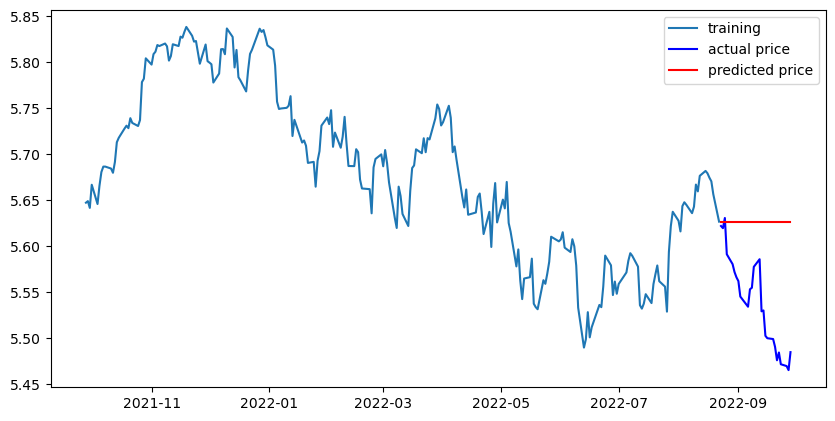

In [151]:
# Forecast : 결과가 fc에 담깁니다. 
microsoft_fore = microsoft_arima_fit.forecast(len(microsoft_test), alpha=0.05)  # 95% conf
microsoft_fore.index = microsoft_test.index
# Make as pandas series

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(microsoft_train, label='training')
plt.plot(microsoft_test, c='b', label='actual price')
plt.plot(microsoft_fore, c='r',label='predicted price')
plt.legend()
plt.show()

In [152]:
mse = mean_squared_error(np.exp(microsoft_test), np.exp(microsoft_fore))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(microsoft_test), np.exp(microsoft_fore))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(microsoft_test), np.exp(microsoft_fore)))
print('RMSE: ', rmse)

mape = np.mean(np.abs((np.exp(microsoft_test) - np.exp(microsoft_fore))/np.exp(microsoft_test)))
print('MAPE: {:.2f}%'.format(mape * 100))

MSE:  695.9138433638796
MAE:  23.20576953846162
RMSE:  26.380178986577775
MAPE: 9.38%


## 6.1 이번 프로젝트에서 어려웠던 점

LMS에서 시계열 이론이라든지 검정 결과를 해석하는 방법이라든지 이론대로 했는데도 그래프가 제대로 그려지지 않는 이유등이  
거의 생략되다시피해서 직접 찾아봐야 하는 것이 어려웠는데  
또 구글링을 해봐도 시계열에 대해서 제대로 알려주지 않거나 혹은 매우 어려운 수식으로 이루어져 있었다.  
시계열 분석 자체가 매우 어려운 분야라서 LMS에서도 생략이 된 모양이다.  
그래서 지금 하고 있는 방법이 맞는 건지도 모른 채로 어영부영 프로젝트를 완성하게 되었다.

## 6.2 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

주식 예측을 쉽게 보고 있었는데 막상 해보니 역대급으로 어렵다는 것을 알아냈다.

ARIMA 모수의 이론과 실제가 매우 달라서 어떤 값을 넣어야 할 지 아직도 참 모호하다.  
직감적으로는 우선 p와 q 둘 중 하나는 1 이상이어야 하고 d는 왠만하면 0 아니면 1인 것 같다.

## 6.3 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 Exploration은 루브릭 평가 지표가 매우 온화해서 지표를 맞추는 데는 무언가를 시도할 필요도 없었다.  
하지만 그래프로 예측값과 실제값을 차이를 확인하는 부분에서 엄청난 괴리감이 발생해서  
그래프를 아름답게 그리기 위해 여러 ARIMA 모수를 넣어보는 시도를 했다.

## 6.4 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

이번 루브릭 평가 지표는 매우 온화해서 잘 맞췄다.  
하지만 이번 Exploration의 평가 지표가 온화한 건 어쩌면 당연한 것이다.  
주식 데이터의 특성상 미래를 예측하기에는 매우 어렵기 때문.

## 6.5 회상 혹은 자기 다짐

얼마 전 온라인 팀에서 진행한 전력사용량 데이터 시계열 분석 프로젝트를 봤을 때는  
일정한 규칙이 있고 그 규칙이 아름다워서 재밌겠다고 생각했었는데  
예측하기 매우 힘든 주식으로 시계열 데이터를 처음 맛보니 아주 매콤했다.  
지금까지 살면서 실제가 이론과 거의 인접한 것들만 봐 왔는데  
실제와 이론이 동떨어진 시계열 데이터를 보니 갑갑했다.